#**Multiclass Classification Model**

In [1]:
# Import files MulticlassTest and MulticlassTrain
from google.colab import files

uploaded1 = files.upload()
uploaded2 = files.upload()


Saving MultiClassTrain to MultiClassTrain


Saving MultiClassTest to MultiClassTest


##Importing Necessary Libraries

In [2]:
# importing libraries needed
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

## Load the Dataset


In [3]:
# check if CUDA is available if not then use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the binary train and test datasets
train_df = pd.read_csv("MultiClassTrain")
test_df = pd.read_csv("MultiClassTest")

# Checking size of dataset
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Displaying  first 5 rows of training dataset
print(train_df.head())
print(test_df.head())


Train set shape: (274, 8)
Test set shape: (74, 8)
    UDI Type  Air_temperature_K  Process_Temperature_K  Rotational_Speed_rpm  \
0  4308    L              301.4                  309.9                  1259   
1  4327    L              301.6                  310.1                  1362   
2  4329    L              301.6                  310.1                  1326   
3  4141    L              301.7                  310.2                  1331   
4  4139    L              301.7                  310.2                  1311   

   Torque_Nm  Tool_Wear_min              Failure_Type  
0       63.9             20  Heat Dissipation Failure  
1       55.8             70  Heat Dissipation Failure  
2       48.2             77  Heat Dissipation Failure  
3       61.2             47  Heat Dissipation Failure  
4       57.4             40  Heat Dissipation Failure  
    UDI Type  Air_temperature_K  Process_Temperature_K  Rotational_Speed_rpm  \
0  4779    H              303.6                  312.

##Additional Preprocessing Steps

In [4]:



le_failure = LabelEncoder()

le_failure.fit(train_df["Failure_Type"])


train_df["Failure_Type"] = le_failure.transform(train_df["Failure_Type"])
test_df["Failure_Type"] = le_failure.transform(test_df["Failure_Type"])

le = LabelEncoder()
# Label encode Type column L=0, M=1, H=2
train_df["Type"] = le.fit_transform(train_df["Type"])
test_df["Type"] = le.transform(test_df["Type"])

# Splitting up the traget from the features
X_train = train_df.drop(columns=["Failure_Type"])
y_train = train_df["Failure_Type"]
X_test = test_df.drop(columns=["Failure_Type"])
y_test = test_df["Failure_Type"]

# Normalize numeric features using StandardScalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# printing failure classes to ensure they are all there
print(le_failure.classes_)

['Heat Dissipation Failure' 'Overstrain Failure' 'Power Failure'
 'Random Failures' 'Tool Wear Failure']


##Define Custom Dataset

In [6]:
class MultiMaintenanceDataset(Dataset):

    # constructor
    def __init__(self, features, labels):
        # converts features from Numpy format to Pytorch FloatTensor
        self.X = torch.tensor(features, dtype=torch.float32)


        self.y = torch.tensor(labels.values, dtype=torch.long)

    # Tells Pytorch the length of the dataset
    def __len__(self):
        return len(self.X)

    # Allows Dataset to bahave like a list (allows batching to work)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Creating dataset objects
train_dataset = MultiMaintenanceDataset(X_train_scaled, y_train)
test_dataset = MultiMaintenanceDataset(X_test_scaled, y_test)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining Model Architecture

In [7]:
# NN for multiclass model
class MultiClassClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32), # first layer with 32 neurons
            nn.ReLU(), # ReLU Activation
            nn.Linear(32, 16), # second layer with 16 neurons
            nn.ReLU(), # ReLU Activation
            nn.Linear(16, 5) # output layer with 5 classes
        )

    def forward(self, x):
        return self.model(x) # forward pass



## Initialize The Model

In [8]:
# Getting number of input features
input_dim = X_train_scaled.shape[1]

# Getting number of unique classes
num_classes = len(y_train.unique())

# Create model and move to device
model = MultiClassClassifier(input_size=input_dim, num_classes=num_classes)
model = model.to(device)


## Loss Function and Optimizer

In [9]:
# Initializing loss function of cross entropy loss and Adam optimizer
LossF = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training The Model

In [10]:
# training over 100 epochs
epochs = 100

for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0 # tracking loss for each epoch

    for X_batch, y_batch in train_loader:
        # Moving dataset to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad() # clear previous gradients
        outputs = model(X_batch) # forward pass
        loss = LossF(outputs, y_batch) # Calculating loss
        loss.backward() # back propagation
        optimizer.step() # update weights

        total_loss += loss.item()
    # print the loss at each epoch
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 14.5398
Epoch 2, Loss: 14.0172
Epoch 3, Loss: 13.5374
Epoch 4, Loss: 13.0425
Epoch 5, Loss: 12.5711
Epoch 6, Loss: 12.1440
Epoch 7, Loss: 11.6094
Epoch 8, Loss: 11.0833
Epoch 9, Loss: 10.7548
Epoch 10, Loss: 10.5080
Epoch 11, Loss: 10.2263
Epoch 12, Loss: 9.8638
Epoch 13, Loss: 9.5250
Epoch 14, Loss: 9.4274
Epoch 15, Loss: 9.0443
Epoch 16, Loss: 8.7926
Epoch 17, Loss: 8.5178
Epoch 18, Loss: 8.2154
Epoch 19, Loss: 7.9289
Epoch 20, Loss: 7.6494
Epoch 21, Loss: 7.5012
Epoch 22, Loss: 7.1706
Epoch 23, Loss: 6.9300
Epoch 24, Loss: 6.6488
Epoch 25, Loss: 6.3827
Epoch 26, Loss: 6.1205
Epoch 27, Loss: 5.8606
Epoch 28, Loss: 5.5868
Epoch 29, Loss: 5.4216
Epoch 30, Loss: 5.2972
Epoch 31, Loss: 4.9290
Epoch 32, Loss: 4.8657
Epoch 33, Loss: 4.7928
Epoch 34, Loss: 4.4609
Epoch 35, Loss: 4.2878
Epoch 36, Loss: 4.1042
Epoch 37, Loss: 3.9325
Epoch 38, Loss: 3.7876
Epoch 39, Loss: 3.8265
Epoch 40, Loss: 3.6715
Epoch 41, Loss: 3.4111
Epoch 42, Loss: 3.4246
Epoch 43, Loss: 3.3034
Epoch 44,

## Evaluation

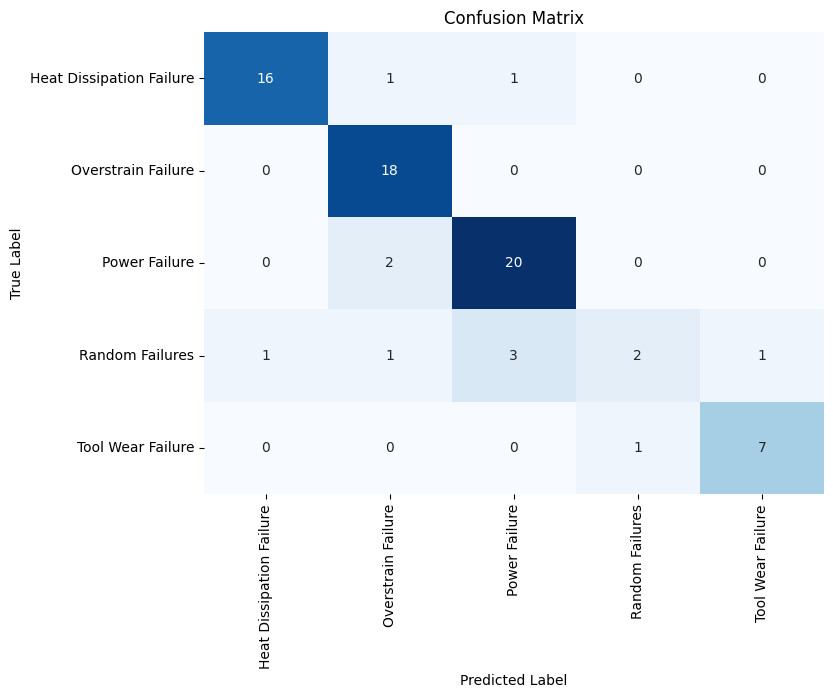


Classification Report:

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.94      0.89      0.91        18
      Overstrain Failure       0.82      1.00      0.90        18
           Power Failure       0.83      0.91      0.87        22
         Random Failures       0.67      0.25      0.36         8
       Tool Wear Failure       0.88      0.88      0.88         8

                accuracy                           0.85        74
               macro avg       0.83      0.78      0.78        74
            weighted avg       0.84      0.85      0.83        74



In [11]:
# setting to evaluation mode
model.eval()
all_preds, all_labels = [], []
# no grad for faster evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)# Forward pass

        # Get the index of the max logit = predicted class
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())# Move to CPU for stacking
        all_labels.extend(y_batch.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix with proper class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le_failure.classes_,
            yticklabels=le_failure.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report with correct target names
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=le_failure.classes_))
